# Import du Dataset

In [6]:
import pandas as pd
import numpy as np

In [7]:
df = pd.read_csv('train.csv')
df.head()

,Unnamed: 0,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,2072,-119.84,36.77,6.0,1853.0,473.0,1397.0,417.0,1.4817,72000.0,INLAND
1,10600,-117.80,33.68,8.0,2032.0,349.0,862.0,340.0,6.9133,274100.0,<1H OCEAN
2,2494,-120.19,36.60,25.0,875.0,214.0,931.0,214.0,1.5536,58300.0,INLAND
3,4284,-118.32,34.10,31.0,622.0,229.0,597.0,227.0,1.5284,200000.0,<1H OCEAN
4,16541,-121.23,37.79,21.0,1922.0,373.0,1130.0,372.0,4.0815,117900.0,INLAND


# Preprocessing

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


X = df.copy()
y = X.pop('median_house_value')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

num_cols = list(X_train.select_dtypes('int64', 'float64').columns)
cat_cols = list(X_train.select_dtypes('object').columns)


num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
], remainder='drop', n_jobs=-1)

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor()
reg = Pipeline(steps = [('preprocessor', preprocessor),
                           ("model", model)])


reg = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE) :', mae)
print('Mean Squared Error (MSE) :', mse)
print('Root Mean Squared Error (RMSE) :', rmse)
print('R-squared (R²) :', r_squared)

Mean Absolute Error (MAE) : 34979.407482106806
Mean Squared Error (MSE) : 3189856726.8991995
Root Mean Squared Error (RMSE) : 56478.816620917256
R-squared (R²) : 0.7621299689552725


In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(reg, X_train, y_train, cv = 5)
print('Cross Validation :', scores, '\nMoyenne :', scores.mean())

Cross Validation : [0.76056606 0.72840311 0.75613543 0.7522737  0.74464149] 
Moyenne : 0.7484039554220917


# Feature Selection

In [11]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import LabelEncoder

X = df.copy()
X['ocean_proximity'] = LabelEncoder().fit_transform(X['ocean_proximity'])
X['total_bedrooms'] = X['total_bedrooms'].fillna(df['total_bedrooms'].mean())
y = X.pop('median_house_value')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

rfe = RFECV(model,cv=5,scoring="neg_mean_squared_error")

rfe.fit(X_train,y_train)

RFECV(cv=5, estimator=RandomForestRegressor(), scoring='neg_mean_squared_error')

In [12]:
rfe.support_

array([ True,  True,  True, False, False, False, False, False,  True,
        True])

In [13]:
rfe.ranking_

array([1, 1, 1, 2, 5, 3, 4, 6, 1, 1])

In [14]:
features = list(X.columns)
selected_features = list(np.array(features)[rfe.get_support()])
print('Meilleurs features à garder :', selected_features)

Meilleurs features à garder : [np.str_('Unnamed: 0'), np.str_('longitude'), np.str_('latitude'), np.str_('median_income'), np.str_('ocean_proximity')]


# Model Tuning

In [15]:
from sklearn.model_selection import GridSearchCV

X = df.copy()
y = X.pop('median_house_value')

X = X[selected_features]
y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

n_estimators = [100, 150, 200, 250, 300]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [10,11,12,13,14,15,16,17,18,19,20]

parameters = {
    'model__n_estimators': n_estimators,
    'model__max_features': max_features,
    'model__max_depth': max_depth
}

model = RandomForestRegressor() 

reg = Pipeline(steps = [('preprocessor', preprocessor),
                           ("model", model)])
 
grid_search = GridSearchCV(reg, parameters, cv=5, scoring='r2', verbose=0)

grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres et du meilleur score
print("Meilleurs paramètres trouvés : ", grid_search.best_params_)
print("Meilleur score de validation croisée : ", grid_search.best_score_)

c:\Users\ryanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
275 fits failed out of a total of 825.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
275 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryanh\App

Meilleurs paramètres trouvés :  {'model__max_depth': 15, 'model__max_features': 'log2', 'model__n_estimators': 300}
Meilleur score de validation croisée :  0.7806558081187742


In [16]:
# Évaluation du meilleur modèle sur l'ensemble de test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
r2_accuracy = r2_score(y_test, y_pred)

print("R² sur l'ensemble de test : ", r2_accuracy)
print("CrossVal sur l'ensemble de test : ", cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2').mean())

R² sur l'ensemble de test :  0.7895482248329007
CrossVal sur l'ensemble de test :  0.7800977727015125


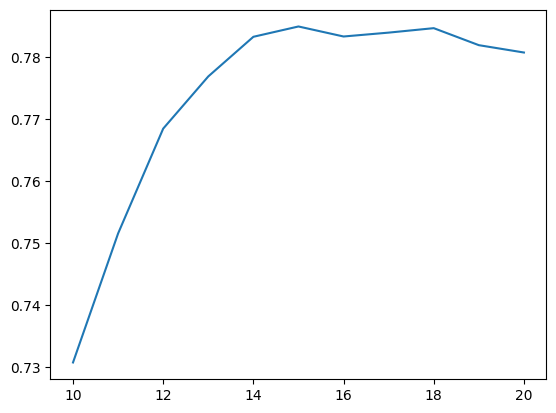

In [17]:
import matplotlib.pyplot as plt

depth = [10,11,12,13,14,15,16,17,18,19,20]
scores = []
for n in depth:
    model = RandomForestRegressor(max_depth=n)
    neigh = Pipeline(steps = [('preprocessor', preprocessor),
                           ("model", model)])

    neigh.fit(X_train, y_train)
    scores.append(neigh.score(X_test, y_test))

plt.plot(depth, scores)
plt.show()

# Export du model

In [21]:
from sklearn.ensemble import RandomForestRegressor
import joblib

# Exemple de création et d'entraînement du modèle
model = best_model
model.fit(X_train, y_train)  # X_train et y_train doivent être définis dans votre script

# Sauvegarde du modèle entraîné
joblib.dump(model, 'model_california.pkl')

['model_california.pkl']